In [53]:
from inputs import two_dimensional_peak, three_dimensional_peak
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.signal
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


%matplotlib inline
import seaborn

In [39]:
def gauss_kernel_fn(d, c, s):
    return c * np.exp(- d**2 / (2 * s**2)) 

c = 1
s = 3

sizes = [10,10]

In [40]:
def pad_flat_matrix(matrix_flat, dims, sizes, mode):
    if mode == 'cyclic':
        pad_mode = 'wrap'
    elif mode == 'zero-filled borders':
        pad_mode = 'constant'
    else: 
        print('Padding mode not known!')
        return matrix_flat
        
    if dims == 1:
            matrix_padded = np.pad(matrix_flat, pad_width=int(sizes[0]/2), mode=pad_mode)

    if dims == 2:
        matrix_padded = np.pad(matrix_flat.reshape(sizes), 
                                 pad_width=((int(sizes[0]/2), int(sizes[0]/2)),
                                            (int(sizes[1]/2), int(sizes[1]/2))),
                                 mode=pad_mode)

    if dims == 3:
        matrix_padded = np.pad(matrix_flat.reshape(sizes), 
                                 pad_width=((int(sizes[0]/2), int(sizes[0]/2)),
                                            (int(sizes[1]/2), int(sizes[2]/2)),
                                            (int(sizes[2]/2), int(sizes[1]/2))),
                                 mode=pad_mode)

    return matrix_padded.flatten()


def compute_kernel(sigma, dims=2):
    
    kernel_width = int(np.ceil(sigma*5))
    if kernel_width % 2 == 0:
        kernel_width += 1
        
#     print(kernel_width)
    if dims == 1 or dims == 0:
        x = np.arange(kernel_width)
        
        cx = kernel_width//2
        if kernel_width % 2 == 0:
            kernel_width -= 0.5
        dx = np.abs(x - cx)
        
    elif dims == 2:
        # create kernel_matrix
        x = np.arange(kernel_width)
        y = np.arange(kernel_width)

        grid_x, grid_y = np.meshgrid(x,y)
        cx, cy = kernel_width//2, kernel_width//2
        if kernel_width % 2 == 0:
            cx -= 0.5
        if kernel_width % 2 == 0:
            cy -= 0.5
        dx = np.sqrt((grid_x-cx)**2 + (grid_y-cy)**2)

    elif dims == 3:
                # create kernel_matrix
        x = np.arange(kernel_width)
        y = np.arange(kernel_width)
        z = np.arange(kernel_width)

        grid_x, grid_y, grid_z = np.meshgrid(x,y,z)
        cx, cy, cz = kernel_width//2, kernel_width//2, kernel_width//2
        if kernel_width % 2 == 0:
            cx -= 0.5
        if kernel_width % 2 == 0:
            cy -= 0.5
        if kernel_width % 2 == 0:
            cz -= 0.5   
        dx = np.sqrt((grid_x-cx)**2 + (grid_y-cy)**2 + (grid_z-cz)**2)
    
        
    kernel_matrix = gauss_kernel_fn(dx, c, sigma)
    # normalize kernel
    kernel_matrix /= np.sum(kernel_matrix)
    
    if dims == 0:
        kernel_matrix = kernel_matrix[cx]
    
    return kernel_matrix


def new_scipy_convolution(inp, boundary, sigma):
    
    kernel_matrix = compute_kernel(sigma)
    
    new_scipy_conv = scipy.signal.convolve2d(inp, kernel_matrix, 
                                         boundary=boundary,
                                         mode='same')
    
    return new_scipy_conv, kernel_matrix


def pad_then_convolve(matrix, kernel, pad_size, boundary):
    
    kw = kernel.shape[0]

    pad_size_f = kw//2
    pad_size_b = kw//2 if kw % 2 == 1 else kw//2 -1
    inp_padded = np.pad(matrix, pad_width=(pad_size_f,pad_size_b),
                        mode=boundary)

    conv = scipy.signal.convolve(inp_padded, kernel,
                                               mode='valid')
   
    return conv
    
    
def scipy_convolve_with_pad(inp, border_type, sigma):
    
    kernel_width = int(np.ceil(sigma*5))
    if kernel_width % 2 == 0:
        kernel_width += 1
        
    dims = len(inp.shape)
    kernel_matrix = compute_kernel(sigma, dims)
    
    boundary = 'constant' if border_type == 'zero-filled borders' else 'wrap'
    pad_size = kernel_width//2
    
    conv = pad_then_convolve(inp, kernel_matrix, pad_size, boundary)

    
    return conv, kernel_matrix    

# 2D convolution example

In [41]:
def convolution_plot(peak, border_type, sizes):
    test_input = np.zeros(sizes)
    test_input[peak[0]-1:peak[0]+2, peak[1]-1:peak[1]+2] = 1
    
    boundary = 'fill' if border_type == 'zero-filled borders' else 'wrap'
    
    conv_scipy_padded, km1 = scipy_convolve_with_pad(test_input, border_type, s)
    conv_scipy_new, km2 = new_scipy_convolution(test_input, boundary, s)
    
    interpolation = 'bilinear'
    
    plt.figure(figsize=(11,3))
    plt.suptitle('Bordertype: %s' %border_type, fontsize=17)
    
    plt.subplot(141)
    plt.title('Sigmoided Input', fontsize=10)
    plt.imshow(test_input, cmap='jet')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(142)
    plt.title('Padded scipy convolution', fontsize=10)
    plt.imshow(conv_scipy_padded, cmap='jet', interpolation=interpolation)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(143)
    plt.title('New scipy convolution', fontsize=10)
    plt.imshow(conv_scipy_new, cmap='jet', interpolation=interpolation)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    
    return conv_scipy_new, conv_scipy_padded, km1, km2

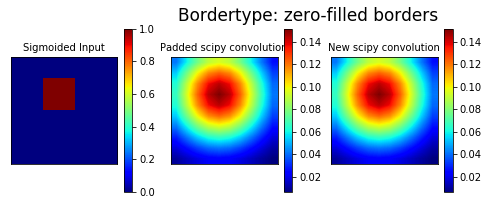

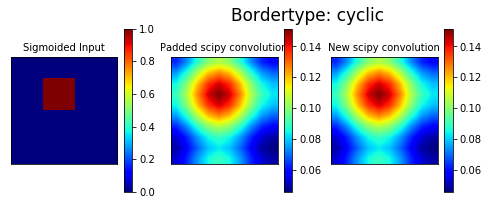

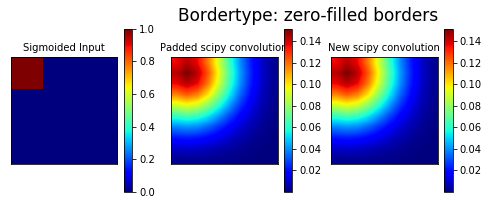

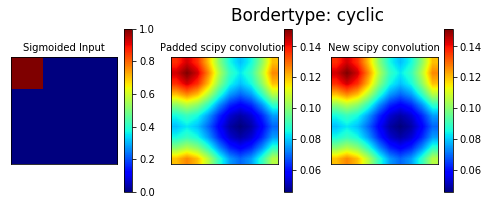

In [42]:
s=3
convolution_plot([3,4], 'zero-filled borders', [10,10])
convolution_plot([3,4], 'cyclic', [10,10])
# print('Convolution results for zero-filled borders')
sci, sci_padded, km1, km2 = convolution_plot([1,1], 'zero-filled borders', [10,10])
# print(np.array_equal(km1, km2)) # use the same kernel
# print((sci-sci_padded) < 10**-10) 
# difference very small, probably due to floating point errors
arrays = convolution_plot([1,1], 'cyclic', [10,10])

# 1D convolution example

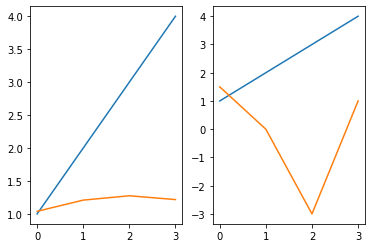

In [43]:
# 1-d and 3-d convolution

input_1d = np.array([1,2,3,4])
kernel = np.array([0.5,-1,2,-3,1])

rs_conv, kernel_ = scipy_convolve_with_pad(input_1d, 
                                          border_type='zero-filled borders', 
                                          sigma=s)

plt.figure()
plt.subplot(121)
plt.plot(input_1d)
# plt.plot(kernel)
plt.plot(rs_conv)

plt.subplot(122)
plt.plot(input_1d)
plt.plot(pad_then_convolve(input_1d, kernel, pad_size=kernel.shape[0]//2, boundary='constant'))

# 3D convolution example

In [44]:
# create sigmoided input as shown by cedar
input_3d = np.zeros((10,10,10))
input_3d[0,:3,:3] = 1
input_3d[1,:3,:3] = 1
input_3d[1,3,1] = 1
input_3d[1,1,3] = 1
input_3d[2,:3,:3] = 1
input_3d[3,1,1] = 1

# or alternatively use a gaussian as input
ampl = 6.5
std = 3.
# input_3d = three_dimensional_peak(1,1,1,std,ampl,10)

# kernel_3d = np.array([[[-1,1],[0,-1]],[[2,1],[1,1]]])
# print(kernel_3d.shape)
# test_conv_3d = pad_then_convolve(input_3d, kernel_3d, pad_size=kernel_3d.shape[0]//2, boundary='constant')
conv_res_3d, gauss_3d = scipy_convolve_with_pad(input_3d, 
                                                border_type='cyclic',
                                                sigma=1.5)

In [45]:
print(conv_res_3d.shape)

(10, 10, 10)


0.018940211136844926


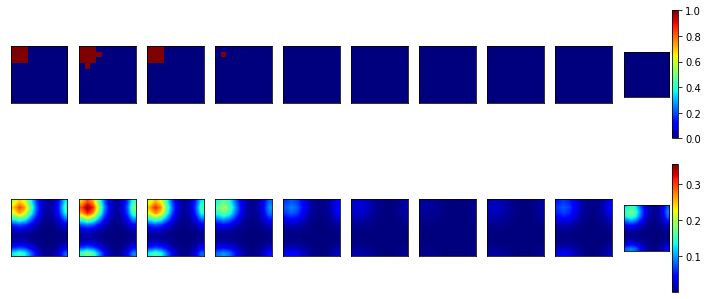

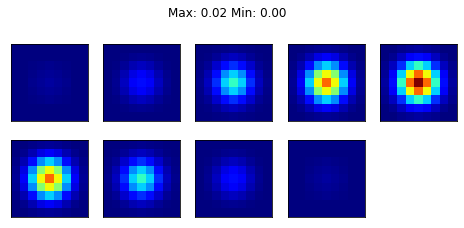

In [46]:
plt.figure(figsize=(12,8))
vmin_inp, vmax_inp = np.min(input_3d), np.max(input_3d)
vmin_conv = np.min(conv_res_3d)
vmax_conv = np.max(conv_res_3d)
vmin_gauss = np.min(gauss_3d)
vmax_gauss = np.max(gauss_3d)
# vmin_test = np.min(test_conv_3d)
# vmax_test = np.max(test_conv_3d)
print(vmax_gauss)

interpolation = 'bilinear'

for i in range(input_3d.shape[2]):
    plt.subplot(3,input_3d.shape[2], i+1)
    plt.imshow(input_3d[i,:,:], cmap='jet', vmin=vmin_inp, vmax=vmax_inp)
    plt.xticks([])
    plt.yticks([])
    if i == input_3d.shape[2] - 1:
        plt.colorbar()
    
    plt.subplot(3,conv_res_3d.shape[2],i+input_3d.shape[2]+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv_res_3d[i,:,:], cmap='jet', vmin=vmin_conv, vmax=vmax_conv,
               interpolation=interpolation)
    if i == input_3d.shape[2] - 1:
        plt.colorbar()
    
#     plt.subplot(3,conv_res_3d.shape[2],i+input_3d.shape[2]*2+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(test_conv_3d[i,:,:], cmap='jet', vmin=vmin_test, vmax=vmax_test)
#     if i == input_3d.shape[2] - 1:
#         plt.colorbar()
    
    
plt.figure(figsize=(8,5))
plt.suptitle('Max: %.2f Min: %.2f' %(vmax_gauss, vmin_gauss))
for i in range(gauss_3d.shape[0]):
    plt.subplot(3,5,i+1)
    plt.imshow(gauss_3d[i,:,:], cmap='jet', vmin=vmin_gauss, vmax=vmax_gauss)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [47]:
print(pad_then_convolve(np.ones((2,2)), np.ones((2,2)),2, boundary='constant'))
scipy.signal.convolve2d(np.ones((2,2)), np.ones((2,2)), boundary='fill' ,mode='same')

[[1. 2.]
 [2. 4.]]


array([[1., 2.],
       [2., 4.]])

In [11]:
k_as_ar = np.array(1.5).reshape([]).flatten()
print(k_as_ar, type(k_as_ar), k_as_ar.shape[0])
print(np.array(1.5), np.array([1.5]))
print(scipy.signal.convolve((np.ones([])*1.5).reshape([]).flatten(), np.array([1.5]), mode='valid'))
np.product([10,10])

[1.5] <class 'numpy.ndarray'> 1
1.5 [1.5]
[2.25]


100

# Plot noise and check noise values

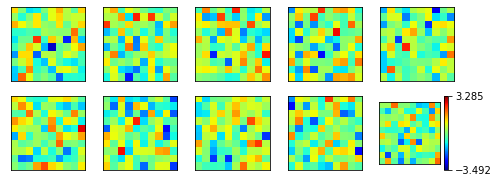

In [48]:
random_noise = np.random.randn(10,10,10)
rn_min = np.min(random_noise)
rn_max = np.max(random_noise)

plt.figure(figsize=(8,3))
for i in range(10):
    
    plt.subplot(2,5,i+1)
    plt.imshow(np.random.randn(10,10), cmap='jet', vmin=rn_min, vmax=rn_max)
    if i == 9:
        plt.colorbar(ticks=[rn_min, rn_max])
    plt.xticks([])
    plt.yticks([])

# Check sigmoid function for differences

In [50]:
class AbsSigmoid(object):
    def __init__(self, beta=100):
        self.beta = beta
    def __call__(self, x):
        return 0.5 * (1 + self.beta * x) / (1 + self.beta * np.abs(x)) + 0.5
    
class ExpSigmoid(object):
    def __init__(self, beta=100):
        self.beta = beta
    def __call__(self, x):
        return 1 / (1 + np.exp(- self.beta * x))

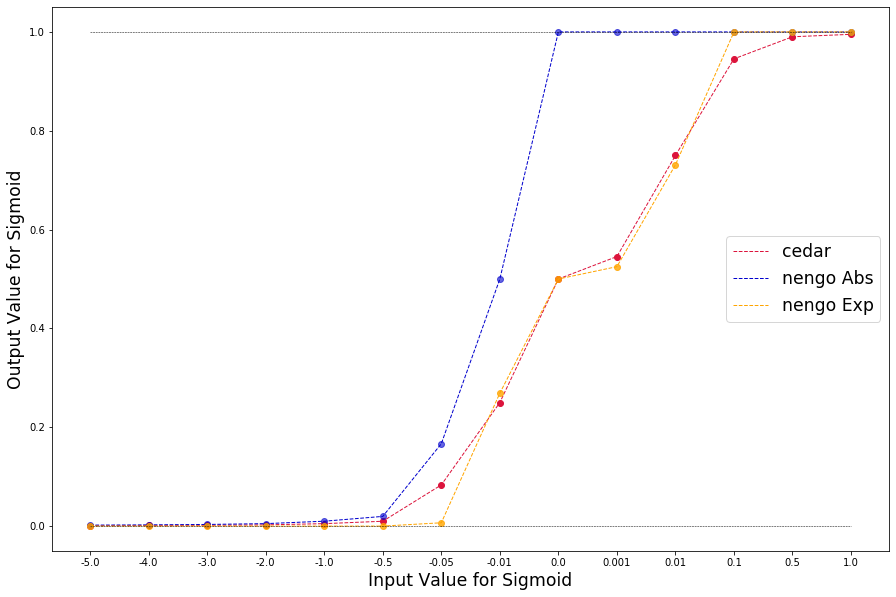

In [59]:
sigmoids_cedar = [0.001, 0.00125, 0.0017, 0.0025, 0.00495, 0.0098, 0.0833, 0.25, 0.5, 
                  0.5454, 0.75, 0.9455, 0.9902, 0.9951]
sigmoid = AbsSigmoid(beta=100)
vals = np.array([-5., -4., -3., -2., -1., -0.5, -0.05, -0.01, 0, 0.001, 0.01, 0.1, 0.5, 1.])
sigmoids_nengo = sigmoid(vals)
sigmoids_exp = ExpSigmoid()(vals)

plt.figure(figsize=(15,10))
vals_str = [str(val) for val in vals]
plt.plot(vals_str, sigmoids_cedar, 'o', c='crimson')
plt.plot(sigmoids_cedar, '--', c='crimson', linewidth=1, label='cedar')
plt.plot(sigmoids_nengo, 'o', c='mediumblue', alpha=0.6)
plt.plot(sigmoids_nengo, '--', c='mediumblue', linewidth=1, label='nengo Abs')
plt.plot(sigmoids_exp, 'o', c='orange', alpha=0.8)
plt.plot(sigmoids_exp, '--', c='orange', linewidth=1, label='nengo Exp')

plt.plot([0,13],[1,1], '--', c='black', linewidth=0.5)
plt.plot([0,13],[0,0], '--', c='black', linewidth=0.5)
plt.xlabel('Input Value for Sigmoid', size='xx-large')
plt.ylabel('Output Value for Sigmoid', size='xx-large')

plt.legend(fontsize='xx-large')
plt.savefig('../Plots/sigmoids.pdf')
plt.show()

# Plot maximum activation development for different taus

In [54]:
nengo_max_act = pd.read_csv('../Data/max_activaton_development_for_taus_3d_nengo.csv', index_col=0)
cedar_max_act = pd.read_csv('../Data/max_activaton_development_for_taus_3d_cedar.csv', header=0, index_col=0)

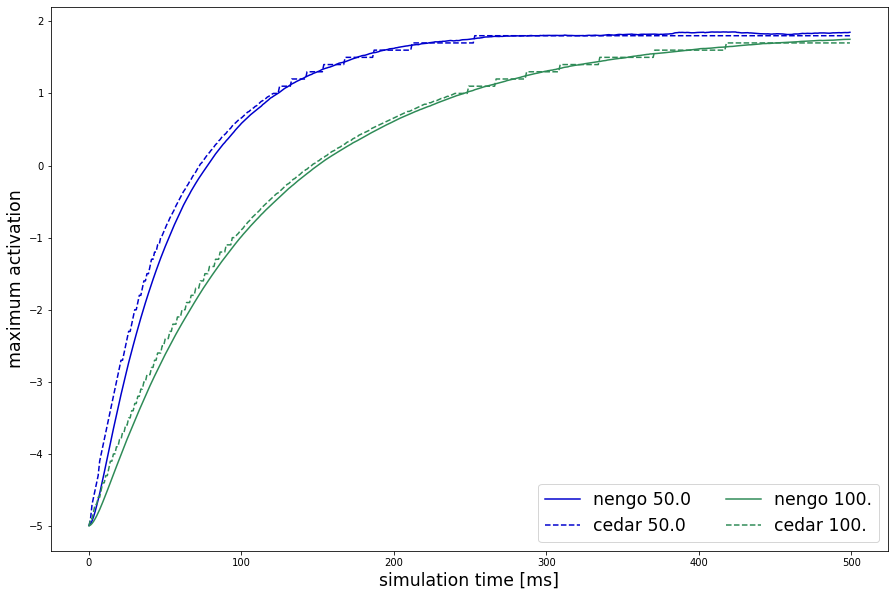

In [55]:
plt.figure(figsize=(15,10))
c = ['mediumblue', 'seagreen', 'crimson', 'orange', 'orangered']
for i, key in enumerate(nengo_max_act.keys()):
    plt.plot(np.arange(0,500,1), nengo_max_act[key][:500], label='nengo %s' %key[:4], c=c[i])
    plt.plot(np.arange(0,500,1), cedar_max_act[key][:500],'--', label='cedar %s' %key[:4], c=c[i])
plt.xlabel('simulation time [ms]', fontsize='xx-large')
plt.ylabel('maximum activation', fontsize='xx-large')
    
plt.legend(loc='lower right', fontsize='xx-large', ncol=2)
# plt.savefig('max_activation_for_taus_3d.pdf')
plt.show()